# LSTM-arithmetic

## Dataset

In [1]:
%%capture
!pip install gdown
!gdown 'https://drive.google.com/uc?id=1cMuL3hF9jefka9RyF4gEBIGGeFGZYHE-'
!unzip arithmetic_NLP.zip

In [2]:
%%capture
!pip install seaborn
!pip install opencc-python-reimplemented
!pip install -U scikit-learn

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn
import torch.nn.utils.rnn
import torch.utils.data
import matplotlib.pyplot as plt
import seaborn as sns
import opencc
import os
from sklearn.model_selection import train_test_split

data_path = '.'

In [4]:
df_train = pd.read_csv(os.path.join(data_path, 'arithmetic_train.csv'), index_col=0).reset_index(drop=True)
df_eval = pd.read_csv(os.path.join(data_path, 'arithmetic_eval.csv'), index_col=0).reset_index(drop=True)
df_train.head()

,src,tgt
0,14*(43+20)=,882
1,(6+1)*5=,35
2,13+32+29=,74
3,31*(3-11)=,-248
4,24*49+1=,1177


In [5]:
# TEST: TRAIN ON SHORT
original_sizes = [len(df_train), len(df_eval)]

df = pd.concat([df_train, df_eval], ignore_index=True)
mask = (df['src'].str.find('9') != -1) | (df['tgt'].astype(str).str.find('9') != -1)

df_train = df[~mask].reset_index(drop=True)
df_eval = df[mask].reset_index(drop=True)

new_sizes = [len(df_train), len(df_eval)]

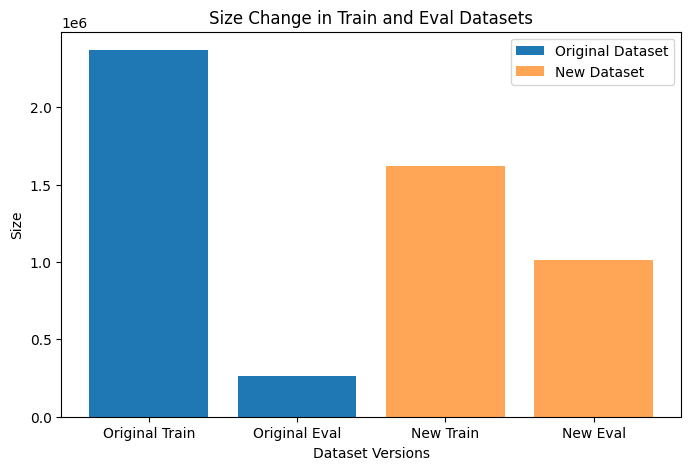

In [6]:
# Plotting the size changes before and after the split
plt.figure(figsize=(8, 5))
plt.bar(['Original Train', 'Original Eval'], original_sizes, label='Original Dataset')
plt.bar(['New Train', 'New Eval'], new_sizes, label='New Dataset', alpha=0.7)
plt.xlabel('Dataset Versions')
plt.ylabel('Size')
plt.title('Size Change in Train and Eval Datasets')
plt.legend()
plt.show()

In [7]:
df_train

,src,tgt
0,14*(43+20)=,882
1,(6+1)*5=,35
2,31*(3-11)=,-248
3,3+(25*25)=,628
4,8*(30+10)=,320
...,...,...
1619970,14*43*23=,13846
1619971,48-(5*27)=,-87
1619972,30*42+16=,1276
1619973,21*(10-15)=,-105


In [8]:
df_eval

,src,tgt
0,13+32+29=,74
1,24*49+1=,1177
2,9*38+49=,391
3,18*22-19=,377
4,47+(29-1)=,75
...,...,...
1012520,41*49*9=,18081
1012521,11+25-49=,-13
1012522,33*(32+9)=,1353
1012523,27+(49-23)=,53


In [9]:
# transform the input data to string
df_train['tgt'] = df_train['tgt'].apply(lambda x: str(x))
df_train['src'] = df_train['src'].add(df_train['tgt'])
df_train['len'] = df_train['src'].apply(lambda x: len(x))

df_eval['tgt'] = df_eval['tgt'].apply(lambda x: str(x))
df_eval['src'] = df_eval['src'].add(df_eval['tgt'])
df_eval['len'] = df_eval['src'].apply(lambda x: len(x))

# Build Dictionary
 - The model cannot perform calculations directly with plain text.
 - Convert all text (numbers/symbols) into numerical representations.
 - Special tokens
    - '&lt;pad&gt;'
        - Each sentence within a batch may have different lengths.
        - The length is padded with '&lt;pad&gt;' to match the longest sentence in the batch.
    - '&lt;eos&gt;'
        - Specifies the end of the generated sequence.
        - Without '&lt;eos&gt;', the model will not know when to stop generating.

In [10]:
char_to_id = {}
id_to_char = {}

# write your code here
# Build a dictionary and give every token in the train dataset an id
# The dictionary should contain <eos> and <pad>
# char_to_id is to convert charactors to ids, while id_to_char is the opposite

numbers = [str(i) for i in range(0, 10)]
operators = ['+', '-', '*', '/', '(', ')', '=']
special_tokens = ['<pad>', '<eos>']

for idx, token in enumerate(numbers + operators + special_tokens):
    char_to_id[token] = idx
    id_to_char[idx] = token

vocab_size = len(char_to_id)
print('Vocab size {}'.format(vocab_size))

Vocab size 19


# Data Preprocessing
 - The data is processed into the format required for the model's input and output.
 - Example: 1+2-3=0
     - Model input: 1 + 2 - 3 = 0
     - Model output: / / / / / 0 &lt;eos&gt;  (the '/' can be replaced with &lt;pad&gt;)
     - The key for the model's output is that the model does not need to predict the next character of the previous part. What matters is that once the model sees '=', it should start generating the answer, which is '0'. After generating the answer, it should also generate&lt;eos&gt;


In [11]:
# Write your code here
def create_char_ids(src: str):
    return [char_to_id[c] for c in (list(src) + ['<eos>'])]

def create_label_ids(char_ids: list):
    idx = char_ids.index(char_to_id['='])
    return [char_to_id['<pad>']] * (idx + 1) + char_ids[idx + 1:]

In [12]:
df_train['char_id_list'] = df_train['src'].map(lambda x: create_char_ids(x))
df_train['label_id_list'] = df_train['char_id_list'].map(lambda x: create_label_ids(x))
df_train

,src,tgt,len,char_id_list,label_id_list
0,14*(43+20)=882,882,14,"[1, 4, 12, 14, 4, 3, 10, 2, 0, 15, 16, 8, 8, 2...","[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 8..."
1,(6+1)*5=35,35,10,"[14, 6, 10, 1, 15, 12, 5, 16, 3, 5, 18]","[17, 17, 17, 17, 17, 17, 17, 17, 3, 5, 18]"
2,31*(3-11)=-248,-248,14,"[3, 1, 12, 14, 3, 11, 1, 1, 15, 16, 11, 2, 4, ...","[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 11, 2..."
3,3+(25*25)=628,628,13,"[3, 10, 14, 2, 5, 12, 2, 5, 15, 16, 6, 2, 8, 18]","[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 6, 2,..."
4,8*(30+10)=320,320,13,"[8, 12, 14, 3, 0, 10, 1, 0, 15, 16, 3, 2, 0, 18]","[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 3, 2,..."
...,...,...,...,...,...
1619970,14*43*23=13846,13846,14,"[1, 4, 12, 4, 3, 12, 2, 3, 16, 1, 3, 8, 4, 6, 18]","[17, 17, 17, 17, 17, 17, 17, 17, 17, 1, 3, 8, ..."
1619971,48-(5*27)=-87,-87,13,"[4, 8, 11, 14, 5, 12, 2, 7, 15, 16, 11, 8, 7, 18]","[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 11, 8..."
1619972,30*42+16=1276,1276,13,"[3, 0, 12, 4, 2, 10, 1, 6, 16, 1, 2, 7, 6, 18]","[17, 17, 17, 17, 17, 17, 17, 17, 17, 1, 2, 7, ..."
1619973,21*(10-15)=-105,-105,15,"[2, 1, 12, 14, 1, 0, 11, 1, 5, 15, 16, 11, 1, ...","[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 1..."


In [13]:
df_eval['char_id_list'] = df_eval['src'].map(lambda x: create_char_ids(x))
df_eval['label_id_list'] = df_eval['char_id_list'].map(lambda x: create_label_ids(x))
df_eval

,src,tgt,len,char_id_list,label_id_list
0,13+32+29=74,74,11,"[1, 3, 10, 3, 2, 10, 2, 9, 16, 7, 4, 18]","[17, 17, 17, 17, 17, 17, 17, 17, 17, 7, 4, 18]"
1,24*49+1=1177,1177,12,"[2, 4, 12, 4, 9, 10, 1, 16, 1, 1, 7, 7, 18]","[17, 17, 17, 17, 17, 17, 17, 17, 1, 1, 7, 7, 18]"
2,9*38+49=391,391,11,"[9, 12, 3, 8, 10, 4, 9, 16, 3, 9, 1, 18]","[17, 17, 17, 17, 17, 17, 17, 17, 3, 9, 1, 18]"
3,18*22-19=377,377,12,"[1, 8, 12, 2, 2, 11, 1, 9, 16, 3, 7, 7, 18]","[17, 17, 17, 17, 17, 17, 17, 17, 17, 3, 7, 7, 18]"
4,47+(29-1)=75,75,12,"[4, 7, 10, 14, 2, 9, 11, 1, 15, 16, 7, 5, 18]","[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 7, 5,..."
...,...,...,...,...,...
1012520,41*49*9=18081,18081,13,"[4, 1, 12, 4, 9, 12, 9, 16, 1, 8, 0, 8, 1, 18]","[17, 17, 17, 17, 17, 17, 17, 17, 1, 8, 0, 8, 1..."
1012521,11+25-49=-13,-13,12,"[1, 1, 10, 2, 5, 11, 4, 9, 16, 11, 1, 3, 18]","[17, 17, 17, 17, 17, 17, 17, 17, 17, 11, 1, 3,..."
1012522,33*(32+9)=1353,1353,14,"[3, 3, 12, 14, 3, 2, 10, 9, 15, 16, 1, 3, 5, 3...","[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 1, 3,..."
1012523,27+(49-23)=53,53,13,"[2, 7, 10, 14, 4, 9, 11, 2, 3, 15, 16, 5, 3, 18]","[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 5..."


# Hyper Parameters

|Hyperparameter|Meaning|Value|
|-|-|-|
|`batch_size`|Number of data samples in a single batch|64|
|`epochs`|Total number of epochs to train|10|
|`embed_dim`|Dimension of the word embeddings|256|
|`hidden_dim`|Dimension of the hidden state in each timestep of the LSTM|256|
|`lr`|Learning Rate|0.001|
|`grad_clip`|To prevent gradient explosion in RNNs, restrict the gradient range|1|

In [14]:
batch_size = 64
epochs = 2
embed_dim = 256
hidden_dim = 256
lr = 0.001
grad_clip = 1

# Data Batching
- Use `torch.utils.data.Dataset` to create a data generation tool called  `dataset`.
- The, use `torch.utils.data.DataLoader` to randomly sample from the `dataset` and group the samples into batches.

In [15]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        # return the amount of data
        return len(self.sequences)
    
    def __getitem__(self, index):
        # Extract the input data x and the ground truth y from the data
        x = self.sequences.iloc[index]['char_id_list'][:-1]
        y = self.sequences.iloc[index]['label_id_list'][1:] 
        return x, y

# collate function, used to build dataloader
def collate_fn(batch):
    batch_x = [torch.tensor(data[0]) for data in batch]
    batch_y = [torch.tensor(data[1]) for data in batch]
    batch_x_lens = torch.LongTensor([len(x) for x in batch_x])
    batch_y_lens = torch.LongTensor([len(y) for y in batch_y])
    
    # Pad the input sequence
    pad_batch_x = torch.nn.utils.rnn.pad_sequence(batch_x,
                                                  batch_first=True,
                                                  padding_value=char_to_id['<pad>'])
    
    pad_batch_y = torch.nn.utils.rnn.pad_sequence(batch_y,
                                                  batch_first=True,
                                                  padding_value=char_to_id['<pad>'])
    
    return pad_batch_x, pad_batch_y, batch_x_lens, batch_y_lens

In [16]:
ds_train = Dataset(df_train)
ds_eval = Dataset(df_eval)

In [17]:
# Build dataloader of train set and eval set, collate_fn is the collate function
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, collate_fn=collate_fn)
dl_eval = torch.utils.data.DataLoader(ds_eval, batch_size, shuffle=True, collate_fn=collate_fn)

# Model Design

## Execution Flow
1. Convert all characters in the sentence into embeddings.
2. Pass the embeddings through an LSTM sequentially.
3. The output of the LSTM is passed into another LSTM, and additional layers can be added.
4. The output from all time steps of the final LSTM is passed through a Fully Connected layer.
5. The character corresponding to the maximum value across all output dimensions is selected as the next character.

## Loss Function
Since this is a classification task, Cross Entropy is used as the loss function.

## Gradient Update
Adam algorithm is used for gradient updates.

In [18]:
class CharRNN(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(CharRNN, self).__init__()
        
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                            embedding_dim=embed_dim,
                                            padding_idx=char_to_id['<pad>'])
        
        self.rnn_layer1 = torch.nn.LSTM(input_size=embed_dim,
                                        hidden_size=hidden_dim,
                                        batch_first=True)
        
        self.rnn_layer2 = torch.nn.LSTM(input_size=hidden_dim,
                                        hidden_size=hidden_dim,
                                        batch_first=True)
        
        self.linear = torch.nn.Sequential(torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=hidden_dim),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=vocab_size))
        
    def forward(self, batch_x, batch_x_lens):
        return self.encoder(batch_x, batch_x_lens)
    
    # The forward pass of the model
    def encoder(self, batch_x, batch_x_lens):
        batch_x = self.embedding(batch_x)
        
        batch_x = torch.nn.utils.rnn.pack_padded_sequence(batch_x,
                                                          batch_x_lens,
                                                          batch_first=True,
                                                          enforce_sorted=False)
        
        batch_x, _ = self.rnn_layer1(batch_x)
        batch_x, _ = self.rnn_layer2(batch_x)
        
        batch_x, _ = torch.nn.utils.rnn.pad_packed_sequence(batch_x,
                                                            batch_first=True)
        
        batch_x = self.linear(batch_x)
        
        return batch_x
    
    def generator(self, start_char, max_len=200):
        char_list = [char_to_id[c] for c in start_char]
        
        next_char = None
        
        while len(char_list) < max_len: 
            
            # Write your code here 
            # Pack the char_list to tensor
            # Input the tensor to the embedding layer, LSTM layers, linear respectively
            batch_x = torch.tensor(char_list).unsqueeze(0)
            batch_x_lens = torch.LongTensor([len(char_list)])
            
            y = self.forward(batch_x, batch_x_lens)
            
            # Use argmax function to get the next token prediction
            next_char = torch.argmax(y, -1)[0, -1].item()
            
            if next_char == char_to_id['<eos>']:
                break
            
            char_list.append(next_char)
            
        return [id_to_char[ch_id] for ch_id in char_list]

In [19]:
torch.manual_seed(2)

# Write your code here. Specify a device (cuda or cpu)
device = torch.device('cuda')
model = CharRNN(vocab_size,
                embed_dim,
                hidden_dim)

In [20]:
# Write your code here. Cross-entropy loss function. The loss function should ignore <pad>
criterion = torch.nn.CrossEntropyLoss(ignore_index=char_to_id['<pad>'])

# Write your code here. Use Adam or AdamW for Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training
1. The outer `for` loop controls the `epoch`
    1. The inner `for` loop uses `data_loader` to retrieve batches.
        1. Pass the batch to the `model` for training.
        2. Compare the predicted results `batch_pred_y` with the true labels `batch_y` using Cross Entropy to calculate the loss `loss`
        3. Use `loss.backward` to automatically compute the gradients.
        4. Use `torch.nn.utils.clip_grad_value_` to limit the gradient values between `-grad_clip` &lt; and &lt; `grad_clip`.
        5. Use `optimizer.step()` to update the model (backpropagation).
2.  After every `1000` batches, output the current loss to monitor whether it is converging.

In [21]:
from tqdm import tqdm
from copy import deepcopy

model = model.to(device)

i = 0
for epoch in range(1, epochs + 1):
    # The process bar
    model.train()
    bar = tqdm(dl_train, desc=f"Train epoch {epoch}")
    
    for batch_x, batch_y, batch_x_lens, batch_y_lens in bar:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        # Write your code here
        # Clear the gradient
        optimizer.zero_grad()
        batch_pred_y = model(batch_x, batch_x_lens)
        
        # Write your code here
        # Input the prediction and ground truths to loss function
        # Back propagation
        loss = criterion(batch_pred_y.permute(0, 2, 1), batch_y.to(device))
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip) # gradient clipping

        # Write your code here
        # Optimize parameters in the model
        optimizer.step()
        
        i += 1
        if i % 50 == 0:
            bar.set_postfix(loss = loss.item())
    
    # Evaluate your model
    model.eval()
    bar = tqdm(dl_eval, desc=f"Validation epoch {epoch}")
    matched = 0
    total = 0
    
    for batch_x, batch_y, batch_x_lens, batch_y_lens in bar:
        with torch.no_grad():
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Write your code here. Input the batch_x to the model and generate the predictions
            batch_pred_y = model(batch_x, batch_x_lens)
            predicted_tokens = torch.argmax(batch_pred_y, dim=-1)
            
            # Write your code here.
            # Check whether the prediction match the ground truths
            # Compute exact match (EM) on the eval dataset
            # EM = correct/total
            for idx, (pred, truth) in enumerate(zip(predicted_tokens, batch_y)):
                # Remove front padding tokens
                start = 0
                for token in truth.tolist():
                    if token != char_to_id['<pad>']: break
                    start += 1
                # Remove back padding tokens
                end = batch_y_lens[idx].item()

                # Exact match check
                if torch.equal(pred[start: end], truth[start: end]):
                    matched += 1
                total += 1
            
    print(matched / total)

Validation epoch 1: 100%|██████████| 15821/15821 [04:23<00:00, 60.04it/s]


0.012003654230759735


Validation epoch 2: 100%|██████████| 15821/15821 [04:24<00:00, 59.90it/s]

0.012195254438162021


In [22]:
torch.save(model, 'model.pkl')

# Generation
Use `model.generator` and provide an initial character to automatically generate a sequence.

In [23]:
model = model.to("cpu")
print("".join(model.generator('1+9*888=')))

1+9*888=658
